
![D.lensalot logo](./../../res/dlensalot2.PNG)

# Interactive minimal working example - OBD matrix
In this tutorial you generate an overlapping B-mode deprojection matrix, and apply it to a noisemodel using a masked sky.
At the end of this tutorial, you will plot the power spectrum of a simulation, with the $B$-modes deprojected using the OBD matrix.

This tutorial uses two configuration files. The [first](https://github.com/NextGenCMB/D.lensalot/blob/sv3.1/lenscarf/ana/config/examples/mwe/conf_mwe_buildOBD.py) is for generating the OBD matrix, and you can freely change the parameters to your liking. 

The 
 * `DLENSALOT_Analysis` is mainly needed for pointing D.lensalot to the mask you will generate in this notebook,
 * `DLENSALOT_Noisemodel` configures the noise model. You should choose the setting applicable to the simulations and/or data you'd like to deproject,
 * `DLENSALOT_OBD` defines where the Matrix temp and final files are stored and other simulation and/or data specific settings

In [2]:
import os
from os.path import join as opj

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

import lenscarf
from lenscarf.run import run
from lenscarf.lerepi.visalot import plot_helper as ph

cond4mpi does not exists
could not setup healpix hack. reverting to standard healpy
MSC: using scarf with 2 OMP threads


# Create mask
The following cell is a template for generating a simple mask and stores it in the `D.lensalot.TEMP` folder. (Make sure that this matches the configuration file setting)

fsky: 0.083


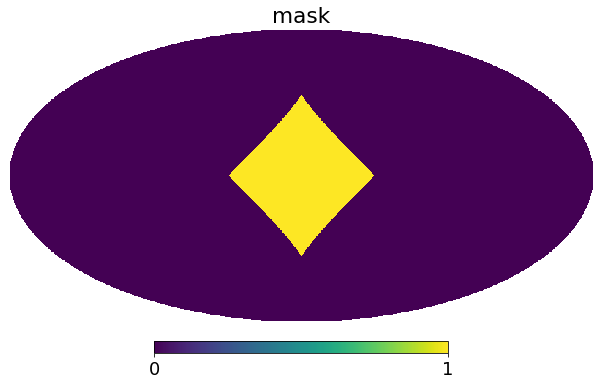

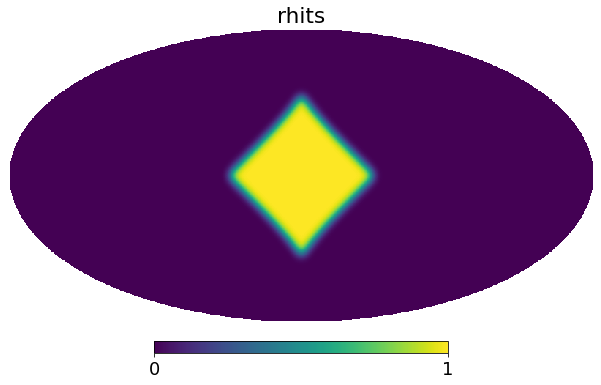

In [172]:
m = np.zeros(hp.nside2npix(1))
m[[4]] = 1
nside = 512
rhits = np.abs(hp.smoothing(hp.ud_grade(m, nside_out=nside),0.1))
mask = hp.ud_grade(m, nside_out=nside)
hp.mollview(mask, title='mask')
hp.mollview(rhits, title='rhits')
fsky = np.mean(m)
print('fsky: {:.3f}'.format(fsky))

mask_fn = opj(os.environ['SCRATCH'], 'OBDmatrix', 'my_first_dlensalot_analysis', 'nside512', 'lmax1024', 'lcut100', 'mask.fits')
rhits_fn = opj(os.environ['SCRATCH'], 'OBDmatrix', 'my_first_dlensalot_analysis', 'nside512', 'lmax1024', 'lcut100', 'rhits.fits')

if not os.path.isdir(os.path.dirname(mask_fn)):
    os.makedirs(os.path.dirname(mask_fn))
    
if not os.path.isfile(mask_fn):
    hp.write_map(mask_fn, mask)
    hp.write_map(rhits_fn, rhits)
    print('mask and rhtis stored at {}'.format(os.path.dirname(mask_fn)))

# Create the OBD matrix
If the sky wasn't masked, deprojecting the B-modes would simply be truncating the transfer function at the respective multipole range.
But due to masking the noise model is no longer isotropic.

To deproject the modes, we will transform the noise model $N$ as follows,

 * $ N^{-1} \rightarrow N^{-1} - P^{\dagger}\left[1/\sigma^2+PN^{-1}P^{\dagger}\right]^{-1}PN^{-1}$

where $\sigma^2$ is a sufficiently high noise value chosen for the modes we want to deproject, and $P$ is the Stokes polarization pattern from a CMB sky. 

The next cell may take a while (~30minutes), go grab a coffee.

In [173]:
fn = opj(os.getcwd(), 'conf_mwe_buildOBD.py')
ana_mwe = run(config=fn, job_id='build_OBD', verbose=True).job
ana_mwe.run()

INFO:: 02-16 04:44:: lenscarf.lerepi.core.handler.log - load_configfile() Started: /global/u2/s/sebibel/git/lenscarf/notebooks/examples/conf_mwe_buildOBD.py
INFO:: 02-16 04:44:: lenscarf.lerepi.core.handler.log - load_configfile() Finished
INFO:: 02-16 04:44:: lenscarf.lerepi.core.handler.log - store() Started
INFO:: 02-16 04:44:: root.store - config file stored at /global/cscratch1/sd/sebibel/OBDmatrix/my_first_dlensalot_analysis/nside512/lmax1024/lcut100/conf_mwe_buildOBD.py
INFO:: 02-16 04:44:: lenscarf.lerepi.core.handler.log - store() Finished
INFO:: 02-16 04:44:: lenscarf.lerepi.core.handler.log - collect_jobs() Started
INFO:: 02-16 04:44:: lenscarf.lerepi.core.handler.log - collect_jobs() Finished
INFO:: 02-16 04:44:: lenscarf.lerepi.core.handler.log - get_jobs() Started
INFO:: 02-16 04:44:: lenscarf.lerepi.core.handler.log - get_jobs() Finished
INFO:: 02-16 04:44:: lenscarf.lerepi.core.handler.log - init_job() Started
INFO:: 02-16 04:44:: lenscarf.lerepi.core.handler.init_job -

In [174]:
print(ana_mwe)

TEMP:                	/global/cscratch1/sd/sebibel/OBDmatrix/my_first_dlensalot_analysis/nside512/lmax1024/lcut100
tr:                  	2
TEMP_suffix:         	('',)
mask_fn:             	/global/cscratch1/sd/sebibel/OBDmatrix/my_first_dlensalot_analysis/nside512/lmax1024/lcut100/mask.fits
lmin_teb:            	(10, 10, 100)
nside:               	512
libdir:              	/global/cscratch1/sd/sebibel/OBDmatrix/my_first_dlensalot_analysis/nside512/lmax1024/lcut100
nlev_dep:            	10000.0
beam:                	1
lmax:                	1024
lmin_b:              	100
geom:                	<scarf.Geometry object at 0x1554f122afb0>
masks:               	<class 'list'>
rhits_map:           	<class 'numpy.ndarray'>
nlev_p:              	1.4142135623730951
ninv_p_desc:         	<class 'list'>
ninv_p:              	<class 'numpy.ndarray'>
jobs:                	<class 'list'>



# Apply to simulation data
The [second](https://github.com/NextGenCMB/D.lensalot/blob/sv3.1/lenscarf/ana/config/examples/mwe/conf_mwe_applyOBD.py) and [third](https://github.com/NextGenCMB/D.lensalot/blob/sv3.1/lenscarf/ana/config/examples/mwe/conf_mwe_applynoOBD.py)
generates a single simulated CMB inclusive of noise and performs QE lensing reconstruction (`job_id="QE_lensrec"`).
QE lensing reconstruction includes the filtering of the CMB maps; exactly what we want.

The difference between the two runs is that one uses OBD, the other just truncates the transfer function at the same multipole range.

In [175]:
fn = opj(os.getcwd(), 'conf_mwe_applyOBD.py')
ana_mwe = run(config=fn, job_id='QE_lensrec', verbose=True).job
ana_mwe.run()

INFO:: 02-16 04:50:: lenscarf.lerepi.core.handler.log - load_configfile() Started: /global/u2/s/sebibel/git/lenscarf/notebooks/examples/conf_mwe_applyOBD.py
INFO:: 02-16 04:50:: lenscarf.lerepi.core.handler.log - load_configfile() Finished
INFO:: 02-16 04:50:: lenscarf.lerepi.core.handler.log - store() Started
INFO:: 02-16 04:50:: lenscarf.lerepi.core.handler.log - load_configfile() Started: /global/cscratch1/sd/sebibel/dlensalot/lenscarf/generic/sims_cmb_len_OBD_my_first_dlensalot_analysis_applyOBD/conf_mwe_applyOBD.py
INFO:: 02-16 04:50:: lenscarf.lerepi.core.handler.log - load_configfile() Finished
INFO:: 02-16 04:50:: root.store - config file look the same. Resuming where I left off last time.
INFO:: 02-16 04:50:: root.store - Matching config file found. Resuming where I left off.
INFO:: 02-16 04:50:: lenscarf.lerepi.core.handler.log - store() Finished
INFO:: 02-16 04:50:: lenscarf.lerepi.core.handler.log - collect_jobs() Started
INFO:: 02-16 04:50:: lenscarf.lerepi.core.handler.lo

In [176]:
fn = opj(os.getcwd(), 'conf_mwe_applynoOBD.py')
ana_mwe = run(config=fn, job_id='QE_lensrec', verbose=True).job
ana_mwe.run()

INFO:: 02-16 04:50:: lenscarf.lerepi.core.handler.log - load_configfile() Started: /global/u2/s/sebibel/git/lenscarf/notebooks/examples/conf_mwe_applynoOBD.py
INFO:: 02-16 04:50:: lenscarf.lerepi.core.handler.log - load_configfile() Finished
INFO:: 02-16 04:50:: lenscarf.lerepi.core.handler.log - store() Started
INFO:: 02-16 04:50:: lenscarf.lerepi.core.handler.log - load_configfile() Started: /global/cscratch1/sd/sebibel/dlensalot/lenscarf/generic/sims_cmb_len_lminB100_my_first_dlensalot_analysis_applynoOBD/conf_mwe_applynoOBD.py
INFO:: 02-16 04:50:: lenscarf.lerepi.core.handler.log - load_configfile() Finished
INFO:: 02-16 04:50:: root.store - config file look the same. Resuming where I left off last time.
INFO:: 02-16 04:50:: root.store - Matching config file found. Resuming where I left off.
INFO:: 02-16 04:50:: lenscarf.lerepi.core.handler.log - store() Finished
INFO:: 02-16 04:50:: lenscarf.lerepi.core.handler.log - collect_jobs() Started
INFO:: 02-16 04:50:: lenscarf.lerepi.core

# Check your result
If the OBD has correctly been applied, the filtered CMB B-map's low $\ell$ $B$-modes are supressed.
The filtered modes are accessed via the `ivfs.ivfs` object, the input simulation data via `_sims`.

In [177]:
fn = opj(os.getcwd(), 'conf_mwe_applynoOBD.py')
ana_mwe_noOBD = run(config=fn, job_id='QE_lensrec', verbose=True).job

fn = opj(os.getcwd(), 'conf_mwe_applyOBD.py')
ana_mwe_OBD = run(config=fn, job_id='QE_lensrec', verbose=True).job

INFO:: 02-16 04:50:: lenscarf.lerepi.core.handler.log - load_configfile() Started: /global/u2/s/sebibel/git/lenscarf/notebooks/examples/conf_mwe_applynoOBD.py
INFO:: 02-16 04:50:: lenscarf.lerepi.core.handler.log - load_configfile() Finished
INFO:: 02-16 04:50:: lenscarf.lerepi.core.handler.log - store() Started
INFO:: 02-16 04:50:: lenscarf.lerepi.core.handler.log - load_configfile() Started: /global/cscratch1/sd/sebibel/dlensalot/lenscarf/generic/sims_cmb_len_lminB100_my_first_dlensalot_analysis_applynoOBD/conf_mwe_applynoOBD.py
INFO:: 02-16 04:50:: lenscarf.lerepi.core.handler.log - load_configfile() Finished
INFO:: 02-16 04:50:: root.store - config file look the same. Resuming where I left off last time.
INFO:: 02-16 04:50:: root.store - Matching config file found. Resuming where I left off.
INFO:: 02-16 04:50:: lenscarf.lerepi.core.handler.log - store() Finished
INFO:: 02-16 04:50:: lenscarf.lerepi.core.handler.log - collect_jobs() Started
INFO:: 02-16 04:50:: lenscarf.lerepi.core

To compare them with one another, we apply a simple inverse variance filter to the simulation data, and show the inverse variance filtered $B$ power spectra for the OBD and trunacted case.

The mismatch at small scales between the (ivfs) and the properly filtered $B$-mode maps is due to the pseudo power spectrum calculation on this small patch.

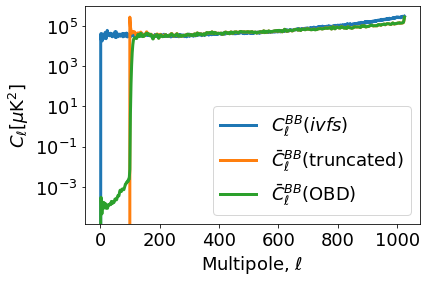

In [180]:
b_sim = ana_mwe_noOBD._sims.get_sim_blm(0)
b_sim_ivfs_noOBD = ana_mwe_noOBD.ivfs.ivfs.get_sim_blm(0)
b_sim_ivfs_OBD = ana_mwe_OBD.ivfs.ivfs.get_sim_blm(0)
N = (ana_mwe_noOBD.nlev_p/180/60*np.pi)**2

plt.plot(hp.alm2cl(b_sim_noOBD)*fsky/(ana_mwe.cls_len['bb'][:1025]+N)**2, label=r'$C_\ell^{BB} (ivfs)$', lw=3)
plt.plot(hp.alm2cl(b_sim_ivfs_noOBD), label=r'$\bar{C}_\ell^{BB}$(truncated)', lw=3)

plt.plot(hp.alm2cl(b_sim_ivfs_OBD), label=r'$\bar{C}_\ell^{BB}$(OBD)', lw=3)

plt.yscale('log')
plt.xlabel('Multipole, $\ell$')
plt.ylabel('$C_\ell [\mu $'+r'$\rm{K}^2$]')
plt.legend()
plt.show()

This concludes the tutorial about applying the OBD matrix to the noise model.
Please check out the other tutorials, our documentation, or GitHub for more.